In [ ]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras

In [ ]:
base_model = keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(50, 50, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [ ]:
def CNN(input_shape=(50, 50, 3), output_class_count=2):
                
    inputs = layers.Input(shape=input_shape,name='Input')

    x = base_model.get_layer('block1_conv1')(inputs)
    x.trainable=False

    x = base_model.get_layer('block1_conv2')(x)
    x.trainable=False


    x = layers.Conv2D(filters=6, kernel_size=5, strides=1,padding='valid',name='conv1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.MaxPool2D(pool_size=2, strides=2,name='S2')(x)
    

# layer 2
    x = layers.Conv2D(filters=16, kernel_size=5,strides=1,padding='valid',name='conv2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=2, strides=2,name='S4')(x)
    
# layer 3
    x = layers.Conv2D(filters=120, kernel_size=5,strides=1,padding='valid',name='conv3')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Flatten()(x)

    x = layers.Dropout(0.1)(x)
    x = layers.Dense(84, activation='relu',name='F6')(x)
    outputs = layers.Dense(units=output_class_count,activation='softmax',name='Output')(x)
    
    model = keras.Model(inputs, outputs)
    return model

In [ ]:
model = CNN((50, 50, 3), 2)
model.load_weights('weights/CNN_weights.h5')

In [115]:
import cv2

test = cv2.imread('datasets/breast-histopathology/IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png', cv2.IMREAD_COLOR)

In [116]:
test = test / 255
test.shape

(50, 50, 3)

In [117]:
# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = cv2.imread('datasets/breast-histopathology/IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png', cv2.IMREAD_COLOR)
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 50, 50, 3)


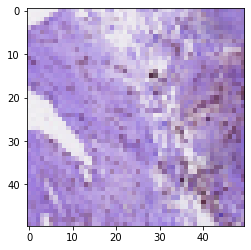

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(img_tensor[0])
plt.show()

In [50]:
from keras import models

# Extracts the outputs of the top 8 layers:
import tensorflow as tf

layer_outputs = []
layer_names = []
for layer in model.layers[1:]:
    
    try: 
        layer_outputs.append(layer.get_output_at(1))
        layer_names.append(layer.name)
    
    except:
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activation_model

In [51]:
layer_names

['block1_conv1',
 'block1_conv2',
 'conv1',
 'batch_normalization',
 're_lu',
 'S2',
 'conv2',
 'batch_normalization_1',
 're_lu_1',
 'S4',
 'conv3',
 'batch_normalization_2',
 're_lu_2',
 'flatten',
 'dropout',
 'F6',
 'Output']

In [45]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

In [64]:
print(len(activations))
print(len(layer_names))

17
17


In [82]:
first_layer_activation = activations[4]
print(first_layer_activation.shape)
first_layer_activation.shape[3]

(1, 46, 46, 6)


6

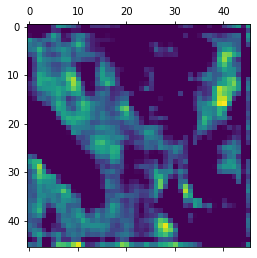

In [78]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')
plt.show()

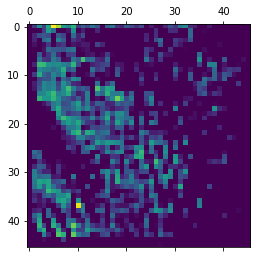

In [79]:
plt.matshow(first_layer_activation[0,:, :, 5], cmap='viridis')
plt.show()

In [138]:
activ = first_layer_activation[0,:, :, 5]

In [139]:
f_min, f_max = activ.min(), activ.max()
filters = (activ - f_min) / (f_max - f_min) 

In [140]:
filters.max()

1.0

In [144]:
import math
def plot_filters(activation_layer, layer_name, counter):

    n = int(np.sqrt(activation_layer.shape[3]))

    if int(n + 0.5) ** 2 == activation_layer.shape[3]:

        m = n
    else:
        m = math.ceil(activation_layer.shape[3] / n)

    fig, ax = plt.subplots(n, m, sharex='col', sharey='row',figsize=(15, 15))
    fig.suptitle(layer_name)
    
    filter_counter = 0
    for i in range(n):
        for j in range(m):
            ax[i, j].imshow(activation_layer[0,:, :, filter_counter], cmap='viridis')
            filter_counter += 1
    
    fig.savefig('img/activations/{}_activations_{}.png'.format(counter, layer_name))
    return None

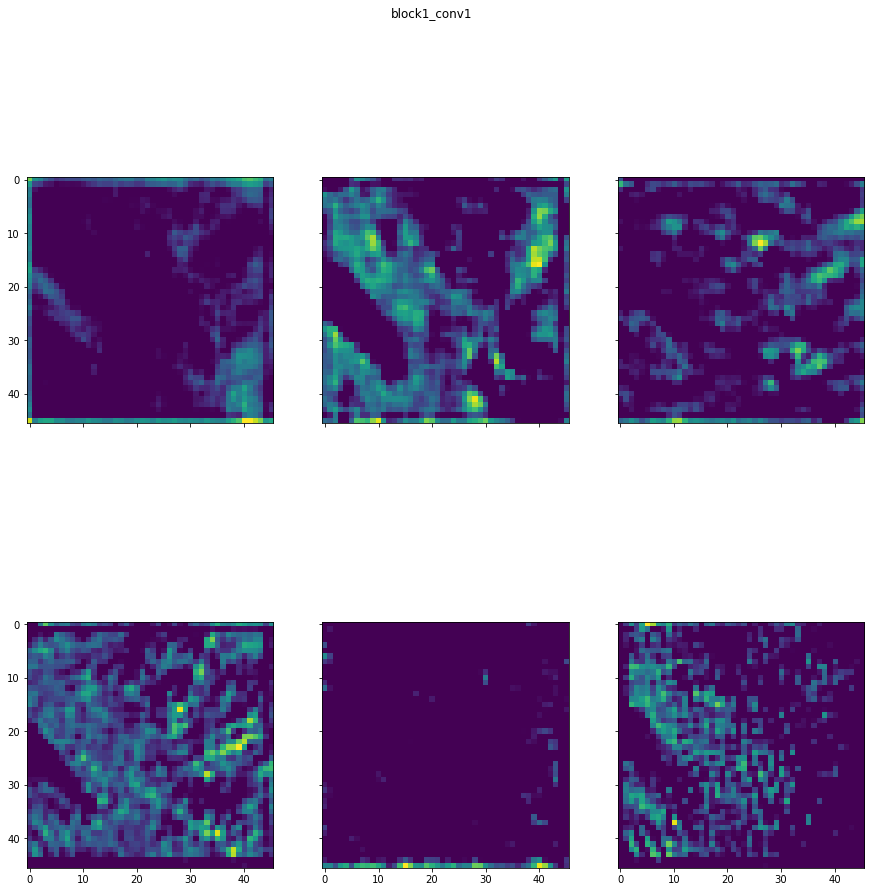

In [142]:
plot_filters(first_layer_activation, layer_names[0], 1)

In [136]:
for activation, name in zip(activations[:-4], layer_names[:-4]):
    print(name)
    print(activation.shape)
    

block1_conv1
(1, 50, 50, 64)
block1_conv2
(1, 50, 50, 64)
conv1
(1, 46, 46, 6)
batch_normalization
(1, 46, 46, 6)
re_lu
(1, 46, 46, 6)
S2
(1, 23, 23, 6)
conv2
(1, 19, 19, 16)
batch_normalization_1
(1, 19, 19, 16)
re_lu_1
(1, 19, 19, 16)
S4
(1, 9, 9, 16)
conv3
(1, 5, 5, 120)
batch_normalization_2
(1, 5, 5, 120)
re_lu_2
(1, 5, 5, 120)


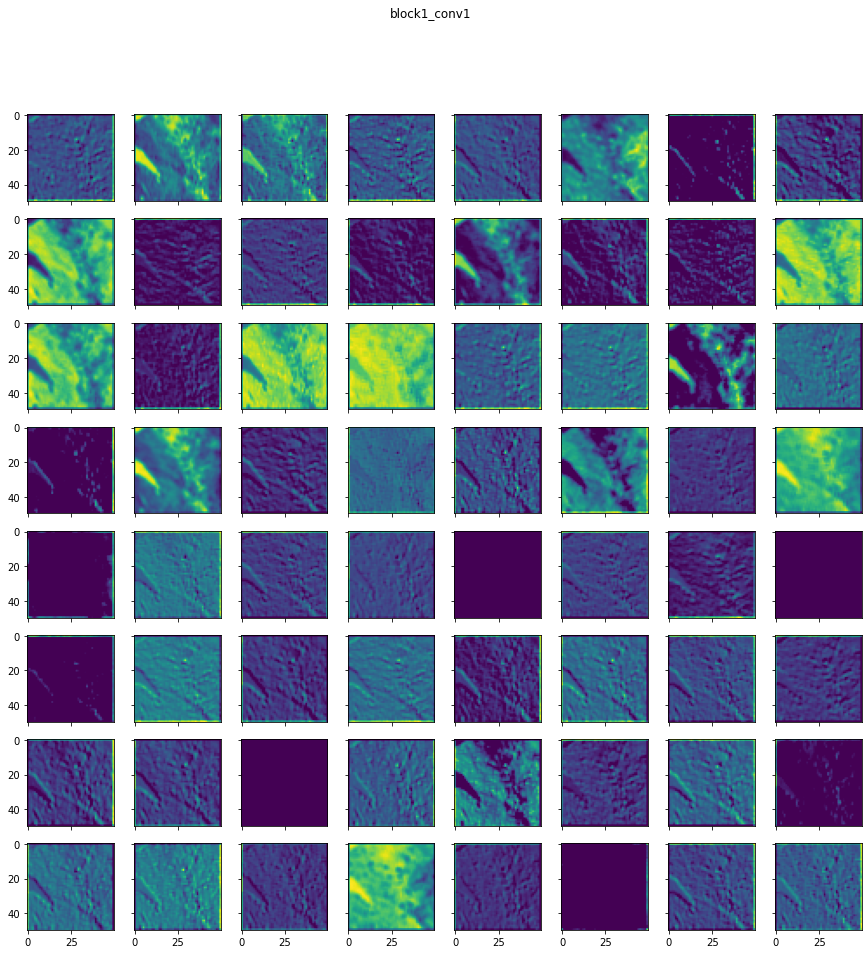

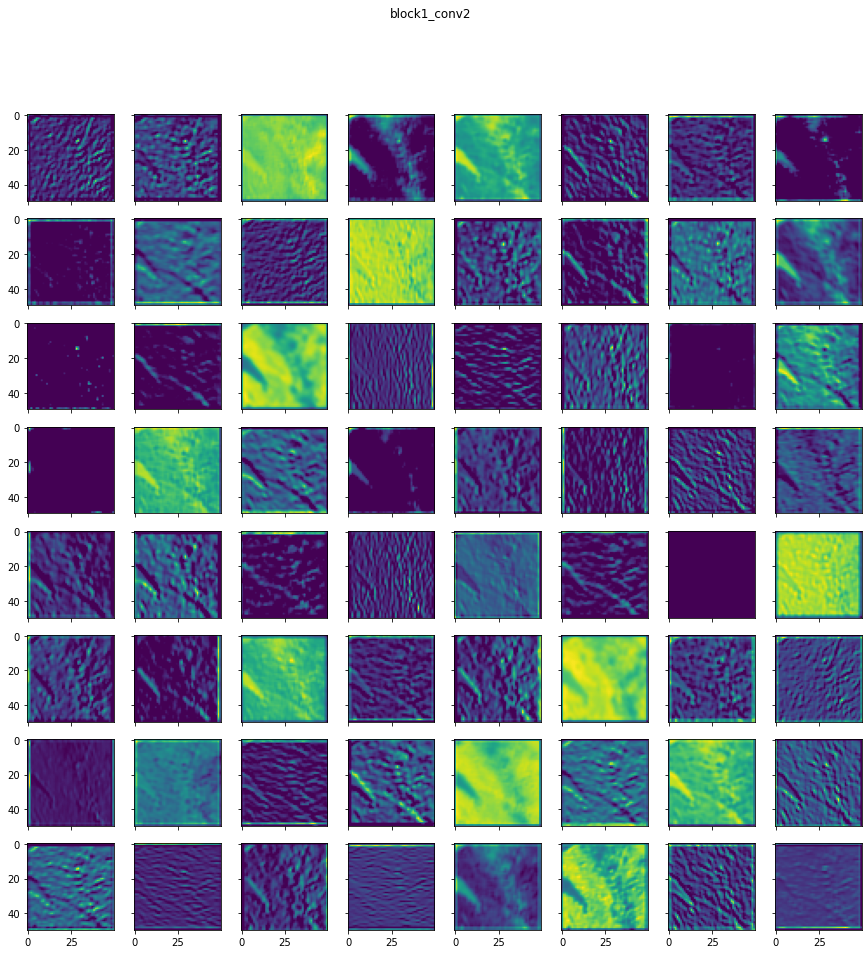

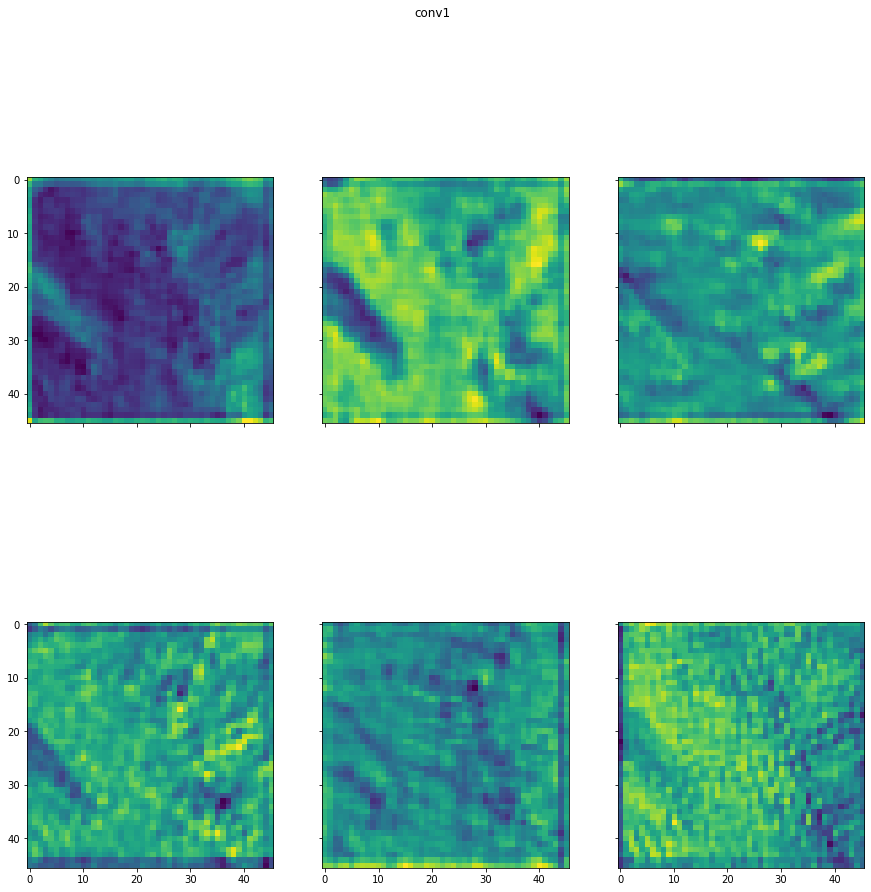

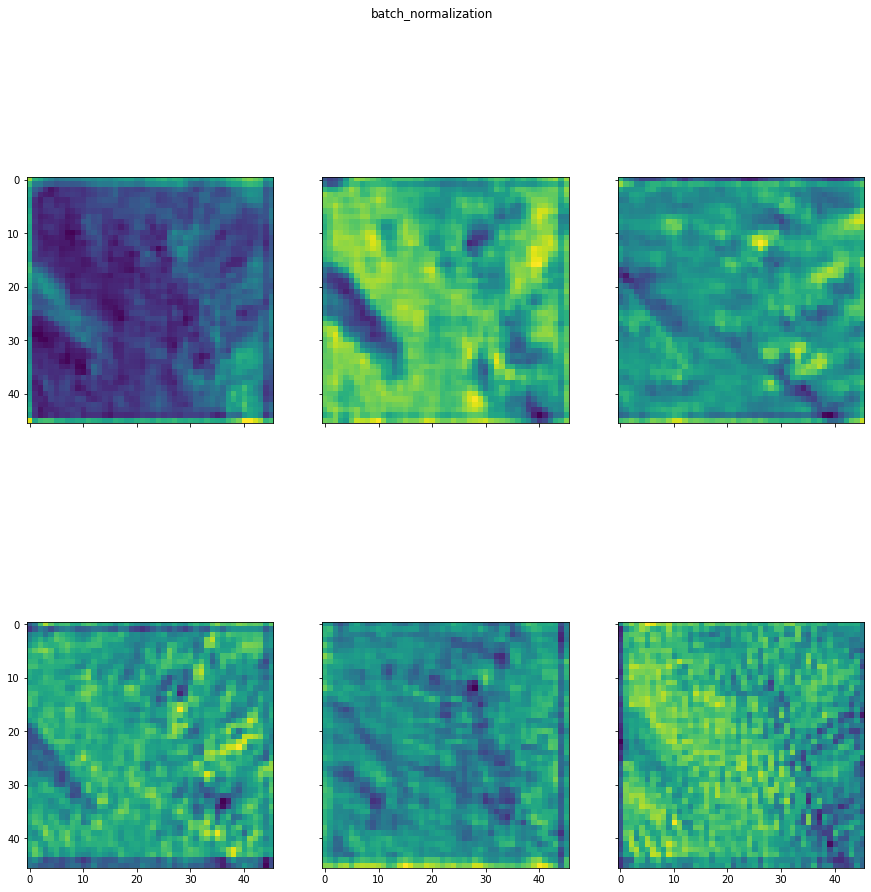

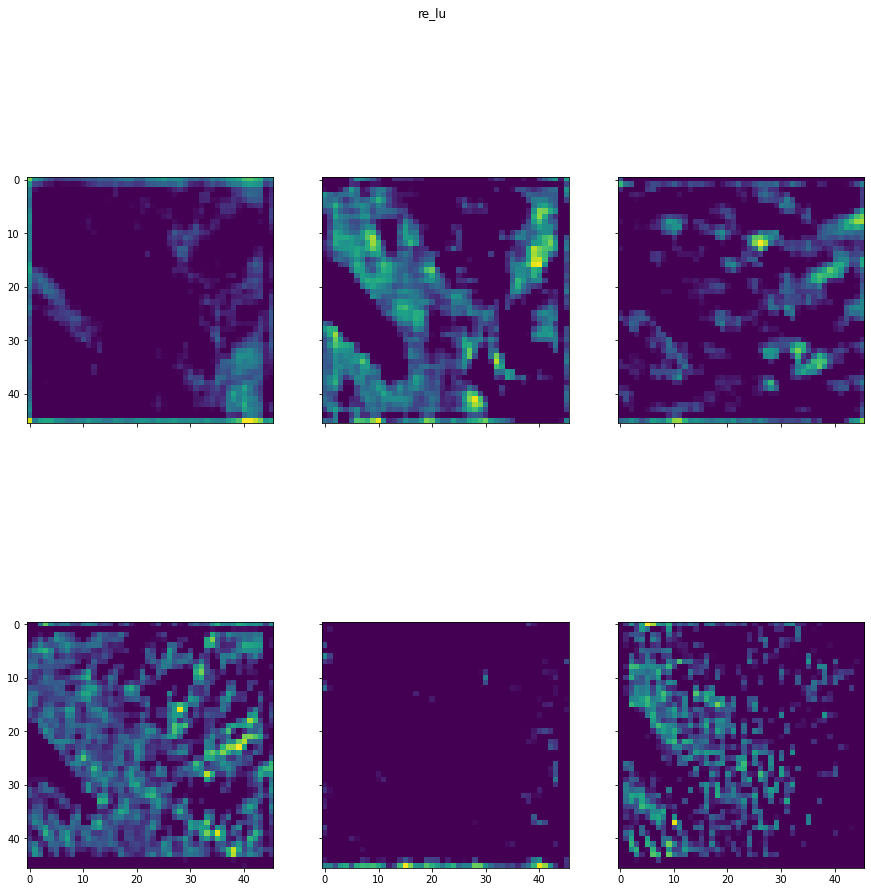

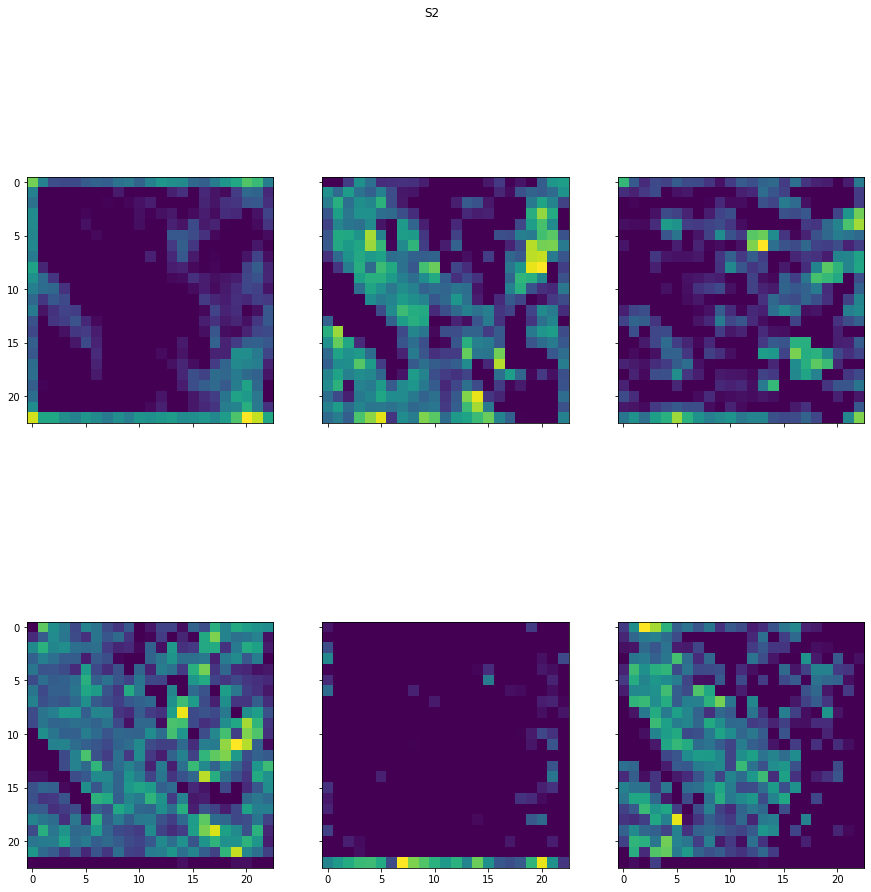

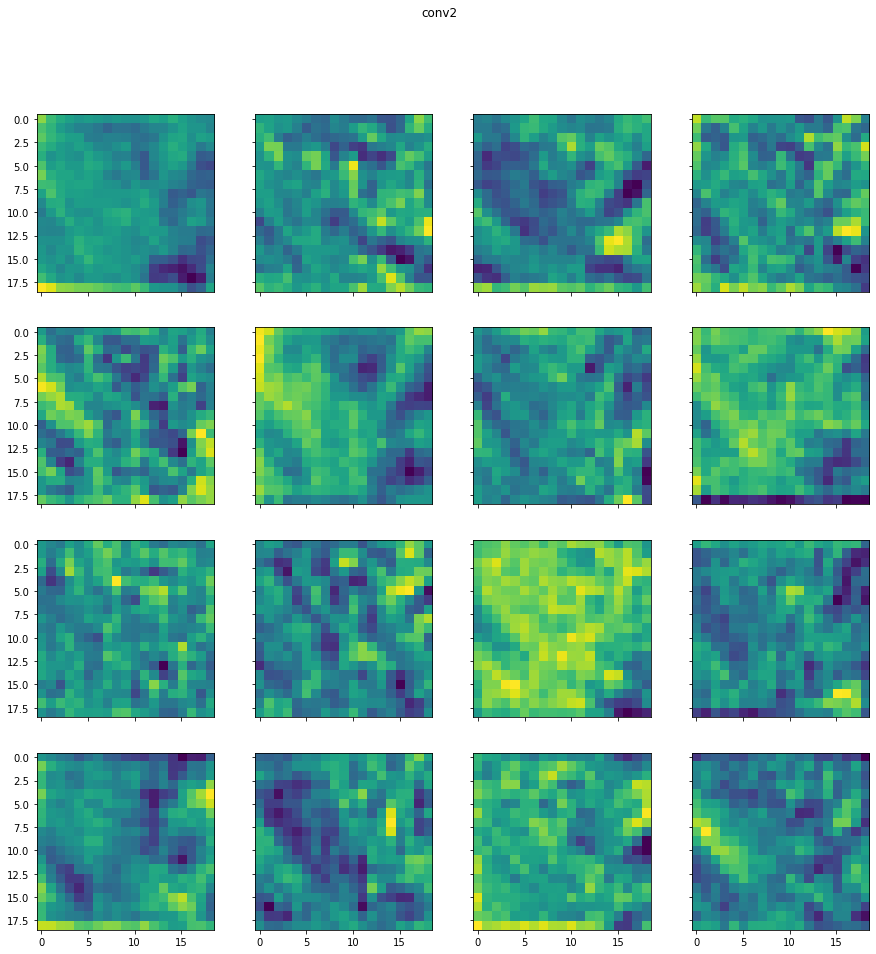

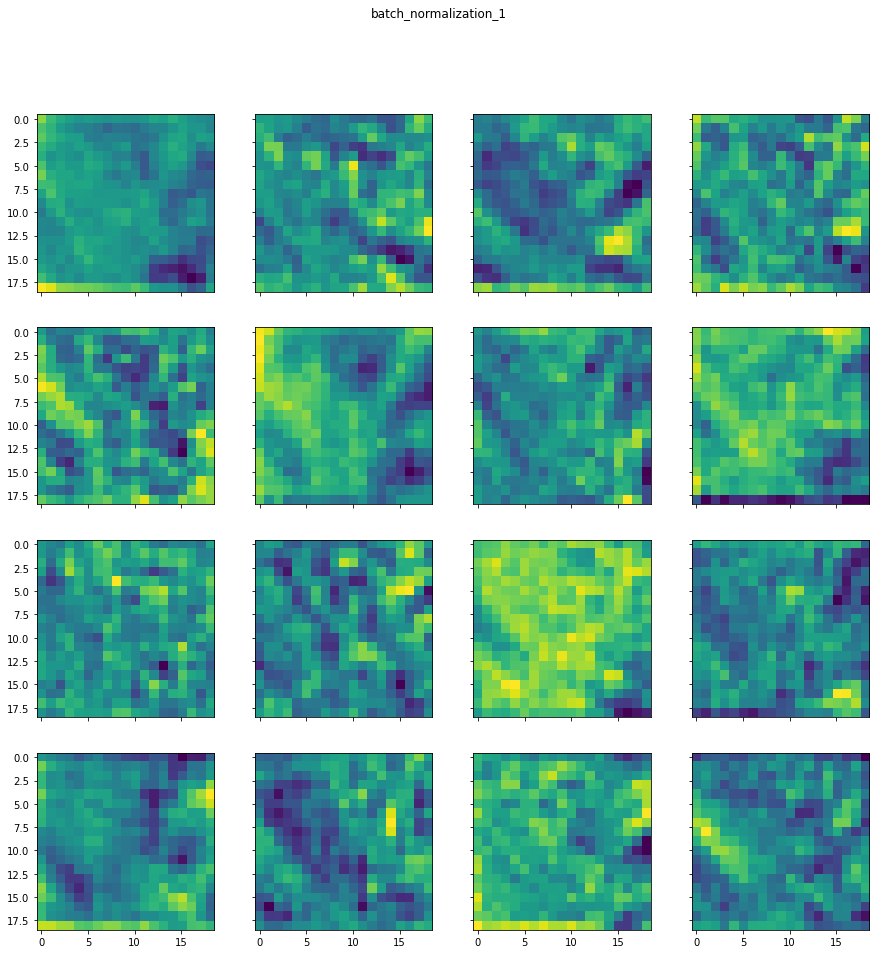

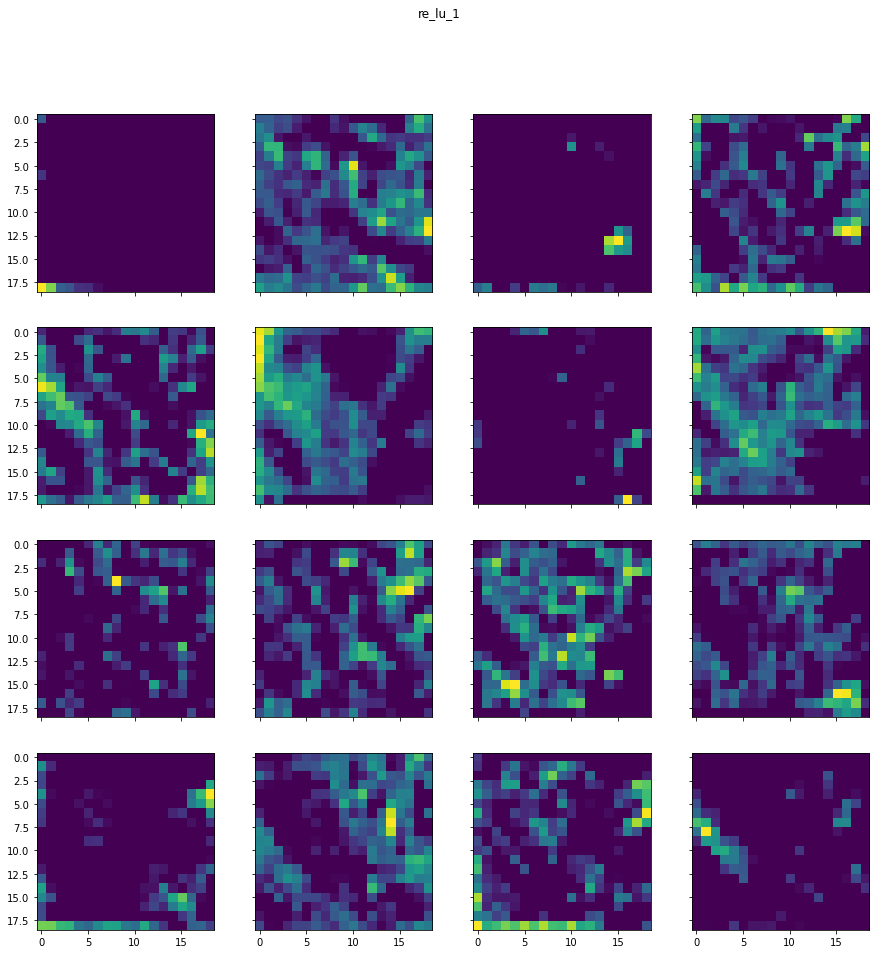

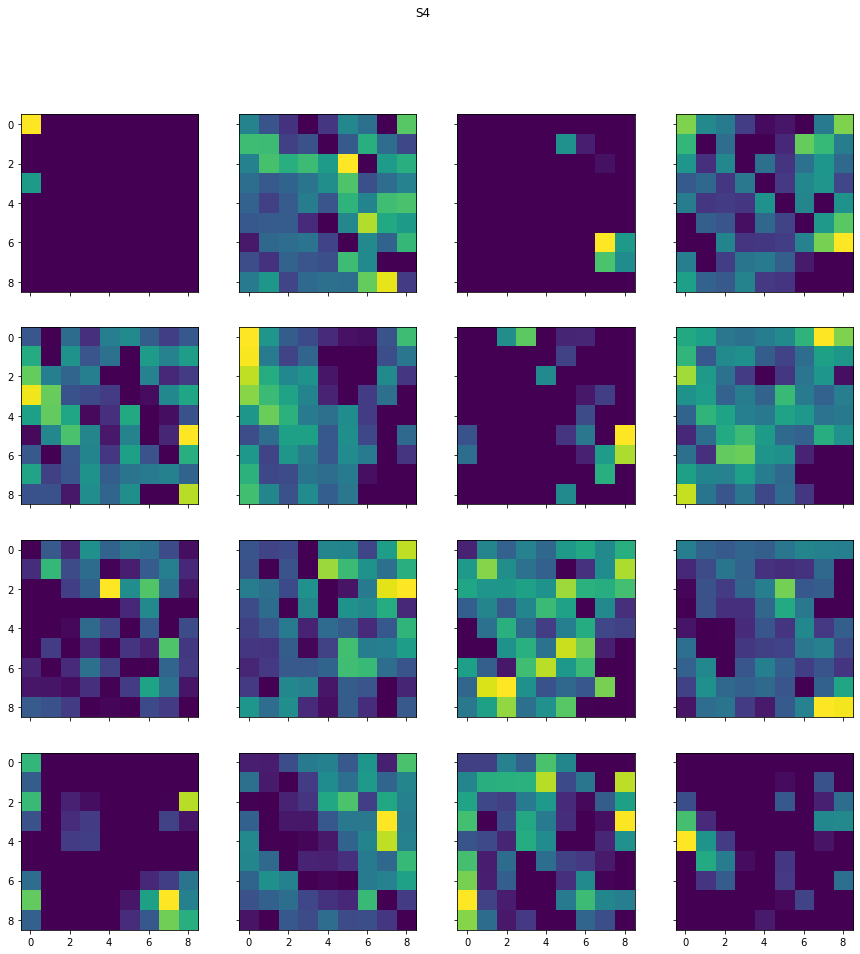

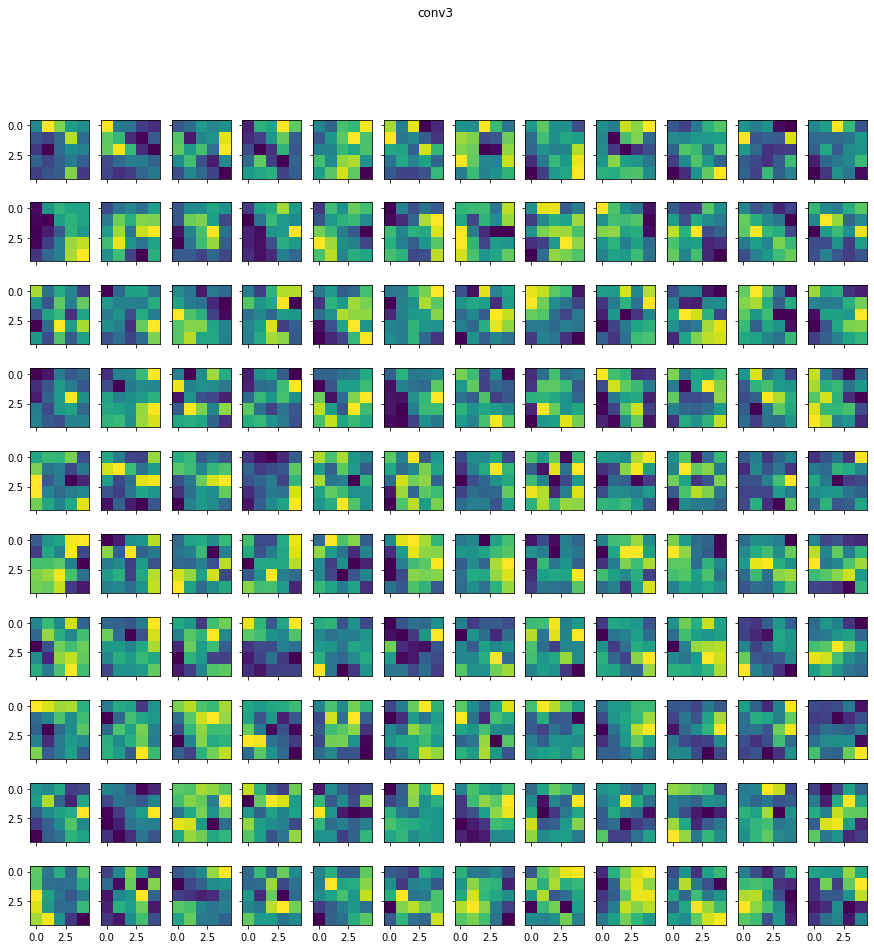

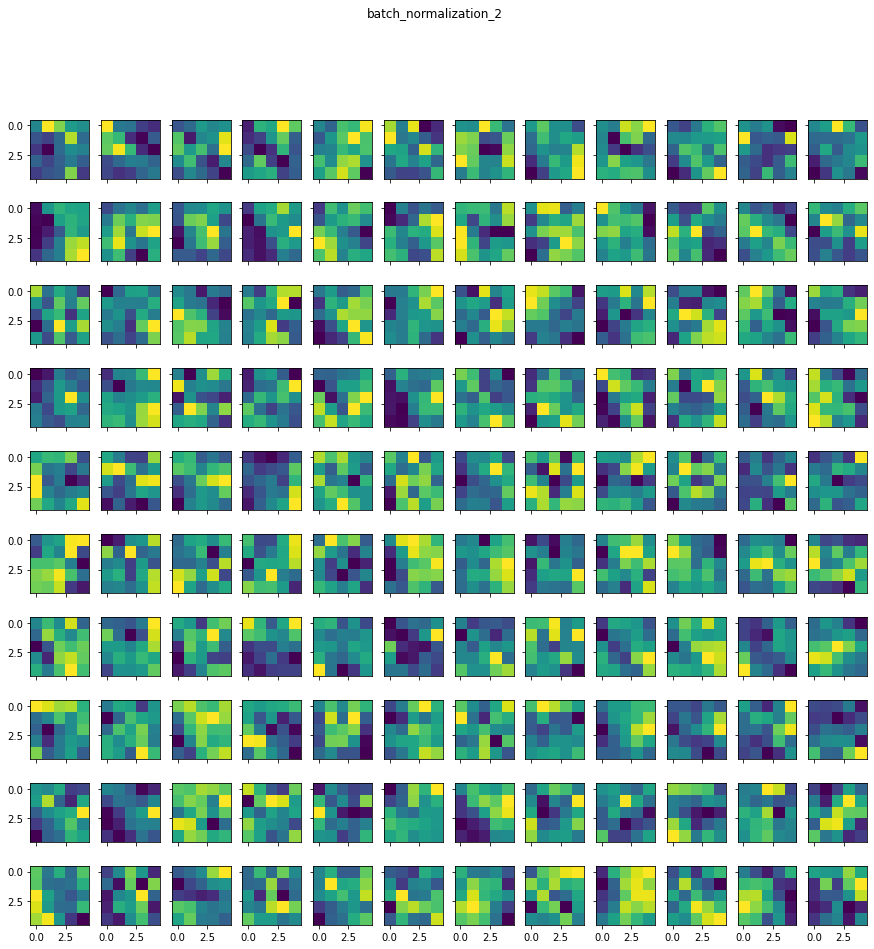

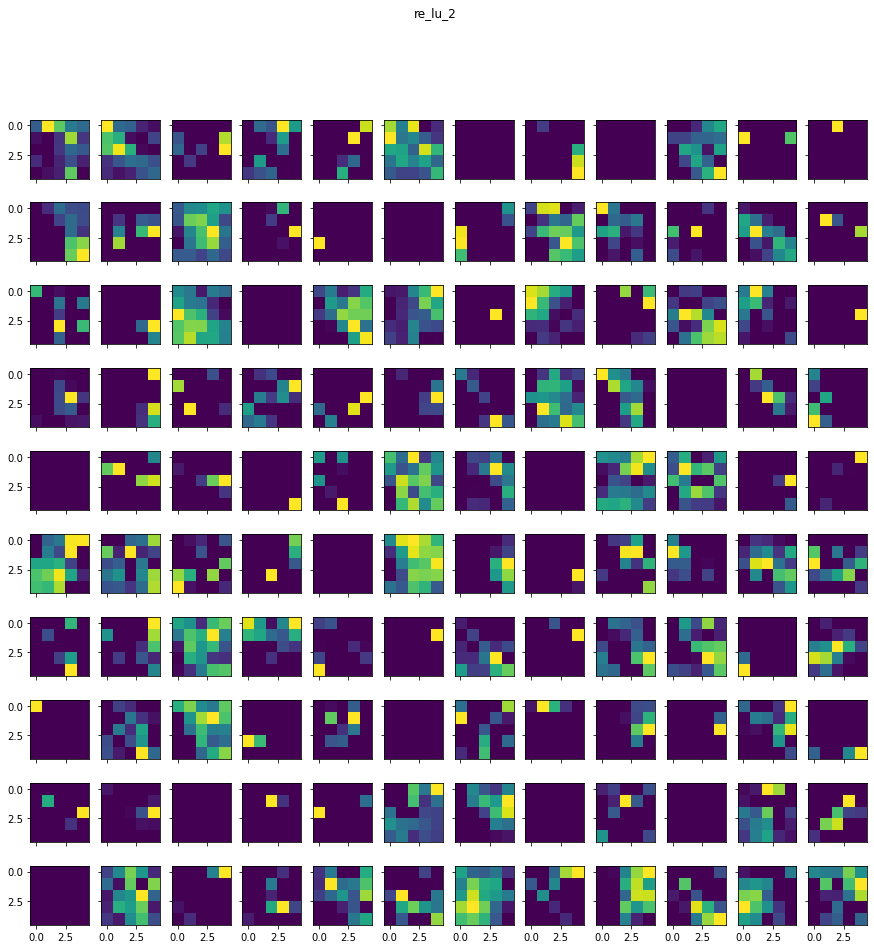

In [145]:
for counter, (activation, name) in enumerate(zip(activations[:-4], layer_names[:-4])):
    plot_filters(activation, name, counter)